In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


# Training and evaluating a sample 1D convnet on IMDB data

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [6]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s - loss: 1.4266 - acc: 0.4954 - val_loss: 0.7156 - val_acc: 0.4968
Epoch 2/10
20000/20000 [==============================] - 2s - loss: 0.6984 - acc: 0.5170 - val_loss: 0.6851 - val_acc: 0.5482
Epoch 3/10
20000/20000 [==============================] - 2s - loss: 0.6704 - acc: 0.5893 - val_loss: 0.6522 - val_acc: 0.6454
Epoch 4/10
20000/20000 [==============================] - 2s - loss: 0.6041 - acc: 0.7057 - val_loss: 0.5606 - val_acc: 0.7228
Epoch 5/10
20000/20000 [==============================] - 2s - loss: 0.4897 - acc: 0.7941 - val_loss: 0.4916 - val_acc: 0.8022
Epoch 6/10
20000/20000 [==============================] - 2s - loss: 0.4203 - acc: 0.8312 - val_loss: 0.4520 - val_acc: 0.8250
Epoch 7/10
20000/20000 [==============================] - 2s - loss: 0.3863 - acc: 0.8479 - val_loss: 0.4606 - val_acc: 0.8342
Epoch 8/10
20000/20000 [==============================] - 2s -

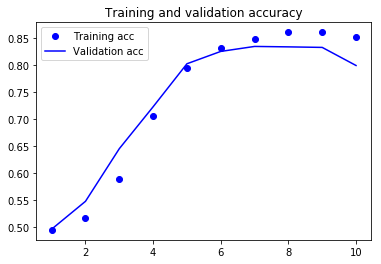

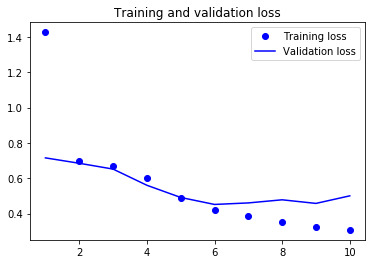

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()